In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os 
import sys

projRootPath =  os.path.abspath(os.path.join('.' ,"../.."))
print("Project root path is: ", projRootPath)
sys.path.append(projRootPath)

from src.utils.path_manipulation import contains_filetype
from src.utils.viz_functions import make_mel_spectrogram
from src.utils.sound_functions import mix_samples, read_mp3, write_mp3, pad_length_to_max

# modules for visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# modules for data processing
import numpy as np
from scipy import signal
from scipy.io import wavfile
import wave
import struct
import csv
import random
from sklearn.preprocessing import StandardScaler

# modules for data mining
from sklearn.decomposition import pca, FastICA

# and IPython.display for audio output
from tqdm.notebook import tqdm 
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

from pydub import AudioSegment

Project root path is:  D:\Programming\AudioMining


In [13]:
# Get data files
dataDirName = "data"
# rawDataDirName = os.path.join("raw", "mp3")
rawDataDirName = "converted_wav"
className1 = "violin"
className2 = "guitar"
data_path1 = os.path.join(projRootPath, dataDirName, rawDataDirName, className1)
data_path2 = os.path.join(projRootPath, dataDirName, rawDataDirName, className2)

# Get all files from data_path 
# r=root, d=directories, f = files
file_extension = ".wav"
(_, d, allFiles) = next(os.walk(data_path1))
soundFiles1 = [f for f in allFiles if f.endswith(file_extension)]

(_, d, allFiles) = next(os.walk(data_path2))
soundFiles2 = [f for f in allFiles if f.endswith(file_extension)]

In [14]:
# Get data files
dataDirName = "data"
# rawDataDirName = os.path.join("raw", "mp3")
rawDataDirName = "converted_wav"
className1 = "violin"
className2 = "guitar"
data_path1 = os.path.join(projRootPath, dataDirName, rawDataDirName, className1)
data_path2 = os.path.join(projRootPath, dataDirName, rawDataDirName, className2)

# Get all files from data_path 
# r=root, d=directories, f = files
file_extension = ".wav"
(_, d, allFiles) = next(os.walk(data_path1))
soundFiles1 = [f for f in allFiles if f.endswith(file_extension)]

(_, d, allFiles) = next(os.walk(data_path2))
soundFiles2 = [f for f in allFiles if f.endswith(file_extension)]

In [15]:
sdata1 = []
sampleRates1 = []
soundFiles = soundFiles1
for indx, file in tqdm(enumerate(soundFiles)):
    fpath = os.path.join(data_path1, file)
#     soundSample, fs = read_mp3(fpath)
    fs, soundSample = wavfile.read(fpath)
    sdata1.append(soundSample)
    sampleRates1.append(fs)
        

In [16]:
sdata2 = []
sampleRates2 = []
soundFiles = soundFiles2
for indx, file in tqdm(enumerate(soundFiles)):
    fpath = os.path.join(data_path2, file)
#     soundSample, fs = read_mp3(fpath)
    fs, soundSample = wavfile.read(fpath)
    sdata2.append(soundSample)
    sampleRates2.append(fs)

print(sdata2[:3])


[array([0, 0, 0, ..., 0, 0, 0], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16)]


In [17]:
### Check that sampling rate is the same
print(min(sampleRates1) == max(sampleRates1))
print(min(sampleRates2) == max(sampleRates2))

True
True


In [32]:
## Select only the samples shorter than threshold
lenThreshold = 300000
sdata1 = [x for x in sdata1 if len(x) <= lenThreshold]
sdata2 = [x for x in sdata2 if len(x) <= lenThreshold]

# random.shuffle(sdata1)
# random.shuffle(sdata2)

## Pad the length of the samples for matrix building
sdata1 = pad_length_to_max(sdata1, lenThreshold)
sdata2 = pad_length_to_max(sdata2, lenThreshold)

# trainset1 = sdata1[:50]
# trainset2 = sdata2[:50]

# valset1 = sdata1[50:100]
# valset2 = sdata2[50:]

# subset1 = random.sample(sdata1, 50)
# subset2 = random.sample(sdata2, 50)




In [33]:
def generate_mixtures(s1, s2, mixing_matrix):
    S = np.c_[s1, s2]
    S = StandardScaler().fit_transform(S)
    A = np.array(mixing_matrix)
    X = np.dot(S, A.T)
    return S, X
    

## Experiment 1:
Try to make ICA with only two sources and two observations

#### Using pca with 2 samples 

c:\users\marius\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


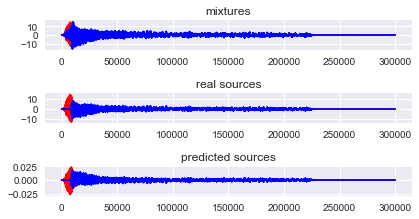

[[-550.5962512  -534.63924472]
 [-278.32790036 -815.03380007]]


In [34]:
s1 = sdata1[0]
s2 = sdata2[0]

mixt_mtx = [[1, 1], [0.5, 1.5]]
S, mixts = generate_mixtures(s1, s2, mixt_mtx)

# print(mixts.shape)

ica = FastICA(n_components=2)
S_recov = ica.fit_transform(mixts) # Reconstruct signals
estimated_mix_mtx = ica.mixing_  # Get estimated mixing matrix

fig = plt.figure()
models = [mixts, S, S_recov]
names = ['mixtures', 'real sources', 'predicted sources']
colors = ['red', 'blue', 'orange']
for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)
        
fig.tight_layout()        
plt.show()

print(estimated_mix_mtx)

In [35]:
IPython.display.Audio(S[:, 0], rate=sampleRates1[2])

In [36]:
IPython.display.Audio(S_recov[:, 0], rate=sampleRates1[2])

In [37]:
IPython.display.Audio(S[:, 1], rate=sampleRates1[2])

In [38]:
IPython.display.Audio(S_recov[:, 1], rate=sampleRates1[2])

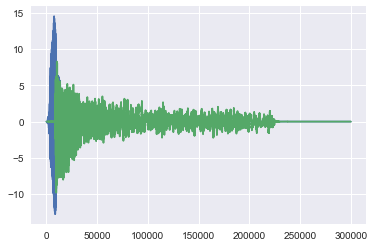

In [39]:
plt.plot(S)

#### Get another mixture and try for the same mixing matrix

In [56]:
s1_v = sdata1[5]
s2_v = sdata2[5]

mixt_mtx_v = [[1, 1], [0.5, 1.5]]
S_v, mixts_v = generate_mixtures(s1_v, s2_v, mixt_mtx_v)
new_mixtures = np.asarray(mixts_v)

c:\users\marius\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [59]:
# print(mixts.shape)

ica = FastICA(n_components=2)
S_recov_v = ica.fit_transform(new_mixtures) # Reconstruct signals
A_recov_v = ica.mixing_  # Get estimated mixing matrix


print(A_)

[[-3.70816945e-11 -3.72774934e-11]
 [-2.96014591e-21 -2.97577608e-21]
 [-2.96014538e-21 -2.97577555e-21]
 ...
 [-2.96014538e-21 -2.97577555e-21]
 [-2.96014538e-21 -2.97577555e-21]
 [-2.96014538e-21 -2.97577555e-21]]


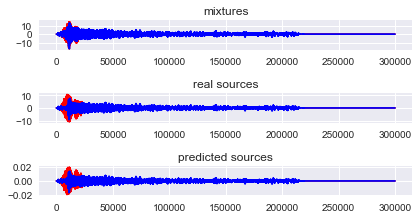

In [60]:
fig = plt.figure()
models = [mixts_v, S_v, S_recov_v]
names = ['mixtures', 'real sources', 'predicted sources']
colors = ['red', 'blue', 'orange']
for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)
        
fig.tight_layout()        
plt.show()


In [61]:
IPython.display.Audio(S_v[:, 0], rate=sampleRates1[2])

In [62]:
IPython.display.Audio(S_recov_v[:, 0], rate=sampleRates1[2])

In [63]:
IPython.display.Audio(S_v[:, 1], rate=sampleRates1[2])

In [64]:
IPython.display.Audio(S_recov_v[:, 1], rate=sampleRates1[2])

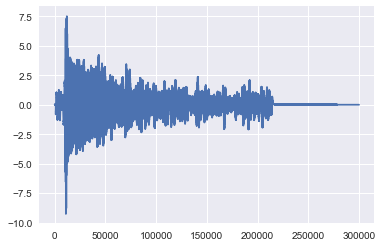

In [65]:
plt.plot(S_v[:, 1])

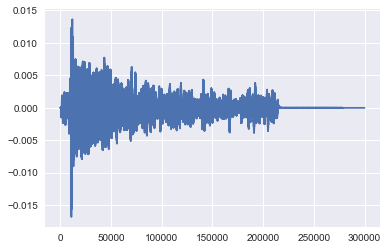

In [66]:
# This recovered signal is still mixed
plt.plot(S_recov_v[:, 1])

#### Try with 3 mixtures

In [ ]:
s1_v = sdata1[5]
s2_v = sdata2[5]

mixt_mtx_v = [[1, 1], [0.5, 1.5]]
S_v, mixts_v = generate_mixtures(s1_v, s2_v, mixt_mtx_v)
new_mixtures = np.asarray(mixts_v)

In [ ]:
# print(mixts.shape)

ica = FastICA(n_components=2)
S_recov_v = ica.fit_transform(new_mixtures) # Reconstruct signals
A_recov_v = ica.mixing_  # Get estimated mixing matrix


print(A_)